In [53]:
%load_ext autoreload
%autoreload 2

In [1]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

# import albumentations as A # Library for augmentations

/home/gareth/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [56]:
# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

           x          y
0  55.077751   8.894347
1 -78.522818 -36.868957
           x          y
0  55.077751   8.894347
1 -78.522818 -36.868957
Original targets:
 ({'boxes': tensor([[ 55.0778, -78.5228,   8.8943, -36.8690]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'area': tensor([-1923.7170]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[ 0.0000,  0.0000,  1.0000],
         [27.1031, 32.3394,  1.0000]]])},) 




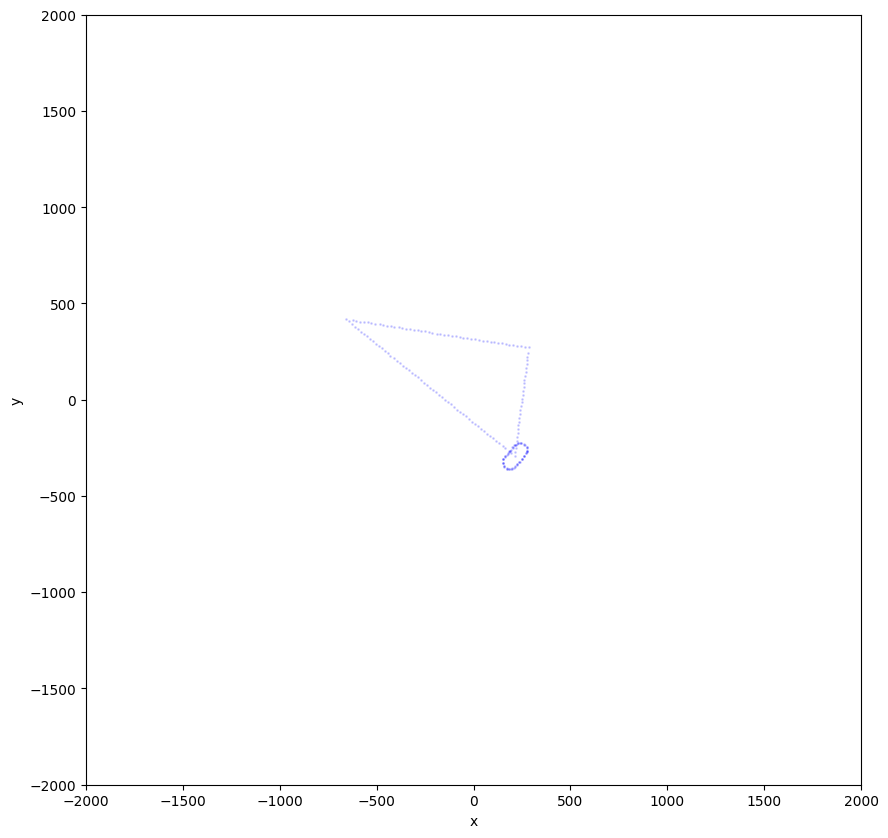

In [58]:
from random_map_generation import random_map
from tools import consistent_scale_plot

IMG_WIDTH = 1000
IMG_HEIGHT = 1000

class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        # self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        # self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        map = random_map()
        
        keypoints = map["keypoints"]
        keypoints = torch.as_tensor([[[x, y, 1] for x, y in zip(keypoints.x.values, keypoints.y.values)]], dtype=torch.float32)

        fig = consistent_scale_plot(map["points"])
        fig.canvas.draw()
        np_fig = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = torch.Tensor([np_fig[0::3], np_fig[1::3], np_fig[2::3]])   # needs to be in C, H, W format. Image is 1000x1000. Colour RGB
        img = torch.reshape(img, (3, IMG_HEIGHT, IMG_WIDTH)) / 255
        bboxes = map["bbox"]
        bboxes = torch.as_tensor([[x for x in bboxes.x.values] + [y for y in bboxes.y.values]], dtype=torch.float32)
        # All objects are tracks
        bboxes_labels = ['track' for _ in bboxes]            

        # img, bboxes, keypoints = img_original, bboxes_original, keypoints_original
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are track
        target["image_id"] = torch.tensor([0])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = keypoints
        # img = F.to_tensor(img)
        
        # bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        # target_original = {}
        # target_original["boxes"] = bboxes_original
        # target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        # target_original["image_id"] = torch.tensor([idx])
        # target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        # target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        # target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        # img_original = F.to_tensor(img_original)

        # if self.demo:
        #     return img, target, img_original, target_original
        # else:
            # return img, target
        return img, target
    
    def __len__(self):
        return 64
    

KEYPOINTS_FOLDER_TRAIN = '/path/to/dataset/train'
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[1], "\n\n")
# print("Transformed targets:\n", batch[1])

[[55, -78, 8, -36]]


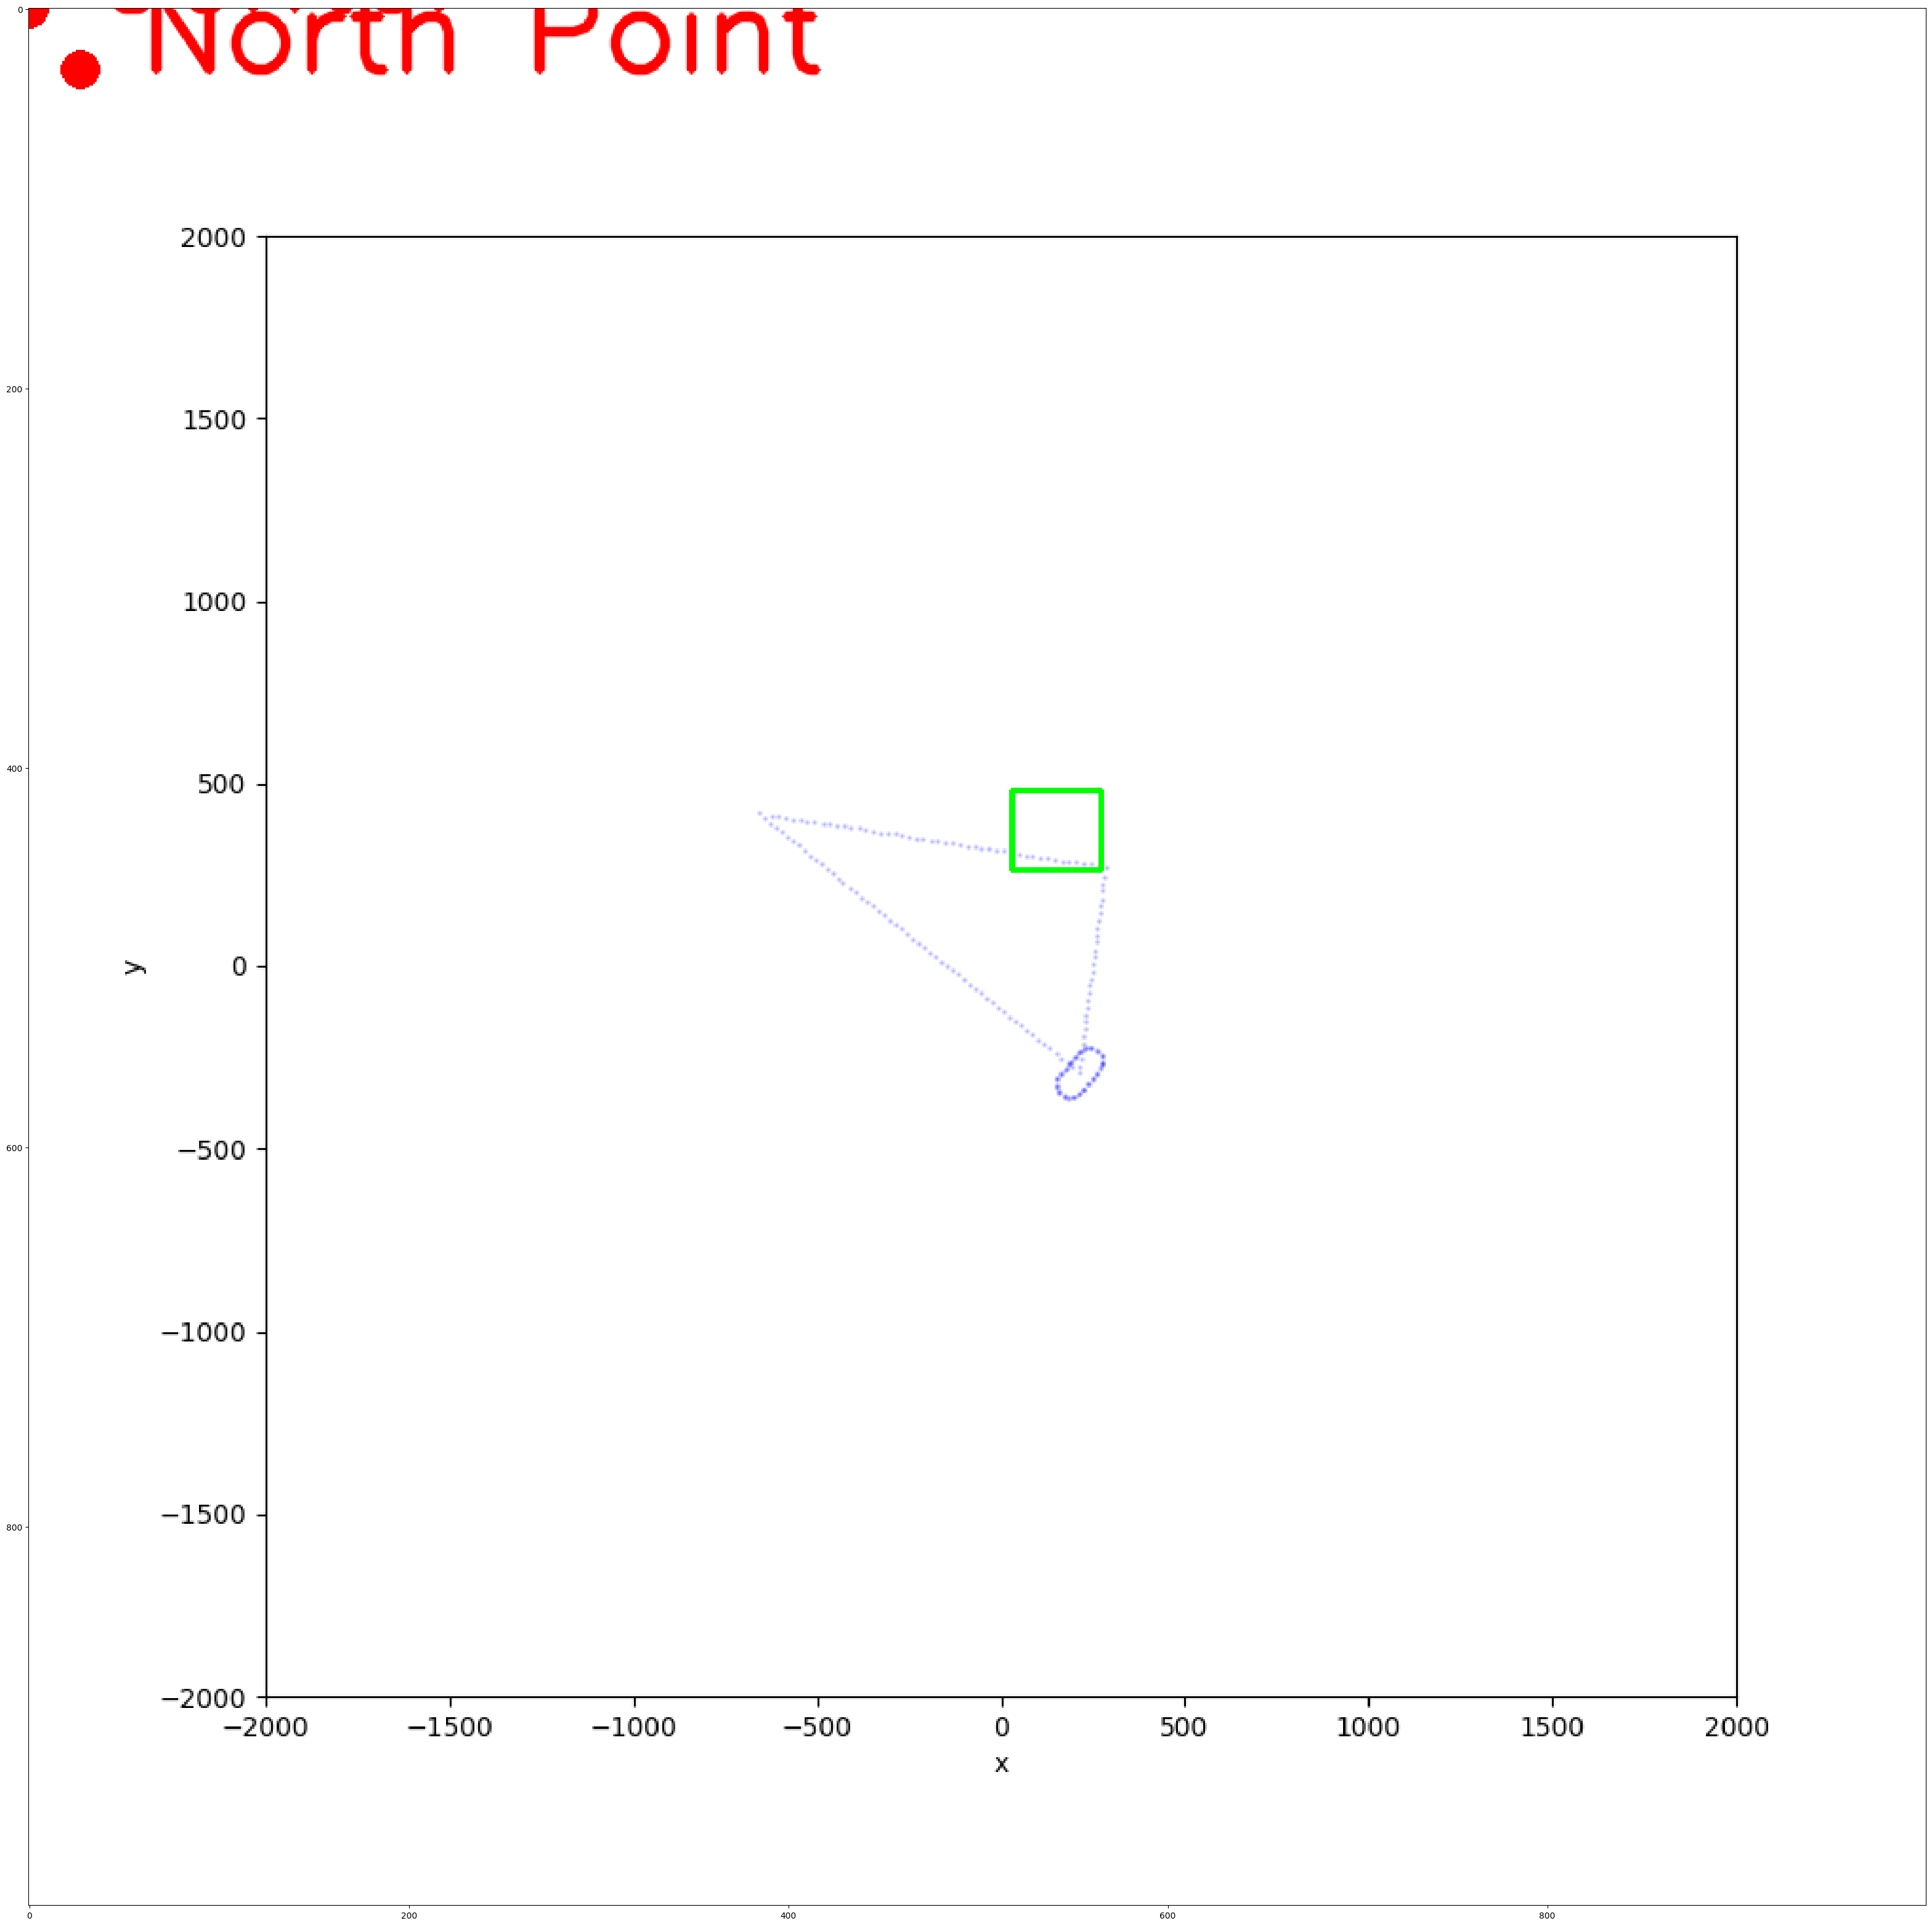

In [59]:
keypoints_classes_ids2names = {0: 'Center', 1: 'North Point'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 12

    LEFT_WIDTH_MARGIN = 40
    RIGHT_WIDTH_MARGIN = 20
    TOP_HEIGHT_MARGIN = 10
    BOTTOM_HEIGHT_MARGIN = 30

    CANVAS_WIDTH = IMG_WIDTH - LEFT_WIDTH_MARGIN - RIGHT_WIDTH_MARGIN
    CANVAS_HEIGHT = IMG_HEIGHT - TOP_HEIGHT_MARGIN - BOTTOM_HEIGHT_MARGIN

    for bbox in bboxes:
        start_point = (bbox[0] + CANVAS_WIDTH // 2 + LEFT_WIDTH_MARGIN, 
                       bbox[1] + CANVAS_HEIGHT // 2 + TOP_HEIGHT_MARGIN)
        end_point = (bbox[2] + CANVAS_WIDTH // 2 + LEFT_WIDTH_MARGIN, 
                     bbox[3] + CANVAS_HEIGHT // 2 + TOP_HEIGHT_MARGIN)
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)
    
    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        

image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

# image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
# bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

# keypoints_original = []
# for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints) #, image_original, bboxes_original, keypoints_original)

In [60]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/gareth/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:27<00:00, 3.79MB/s]


           x          y
0  49.451375  25.830787
1 -62.863619 -59.777241
           x          y
0 -17.265413  53.052555
1  48.515141 -71.912684
          x          y
0  9.658428  54.948911
1  9.081307 -86.270985


AssertionError: All bounding boxes should have positive height and width. Found invalid box [37.97865676879883, -48.279258728027344, 19.838045120239258, -45.90892028808594] for target at index 0.

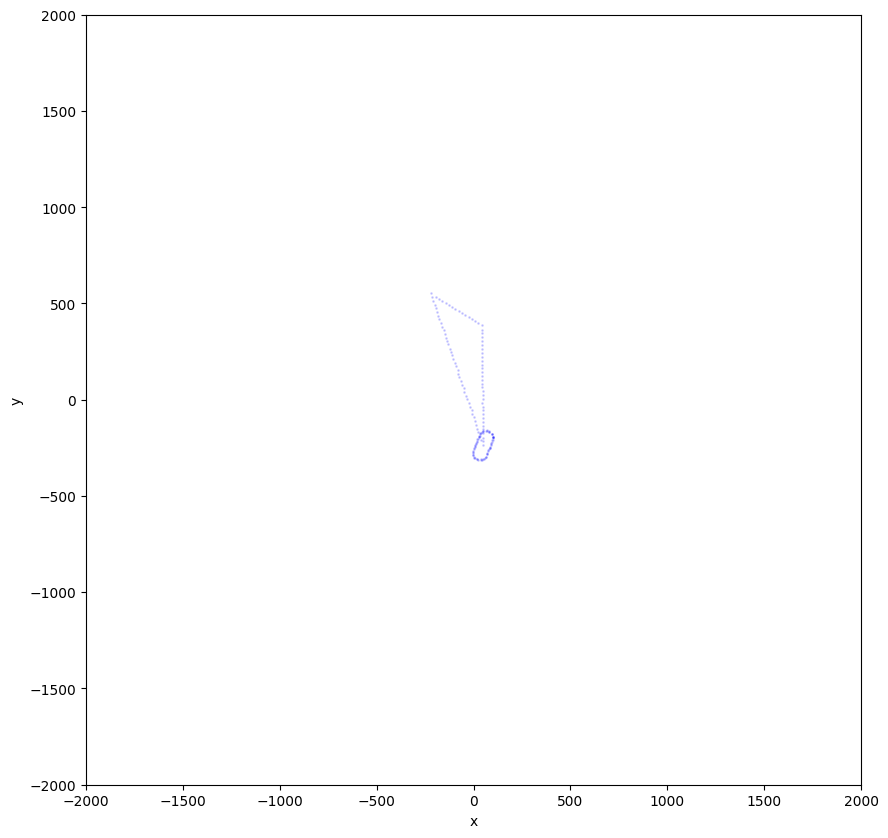

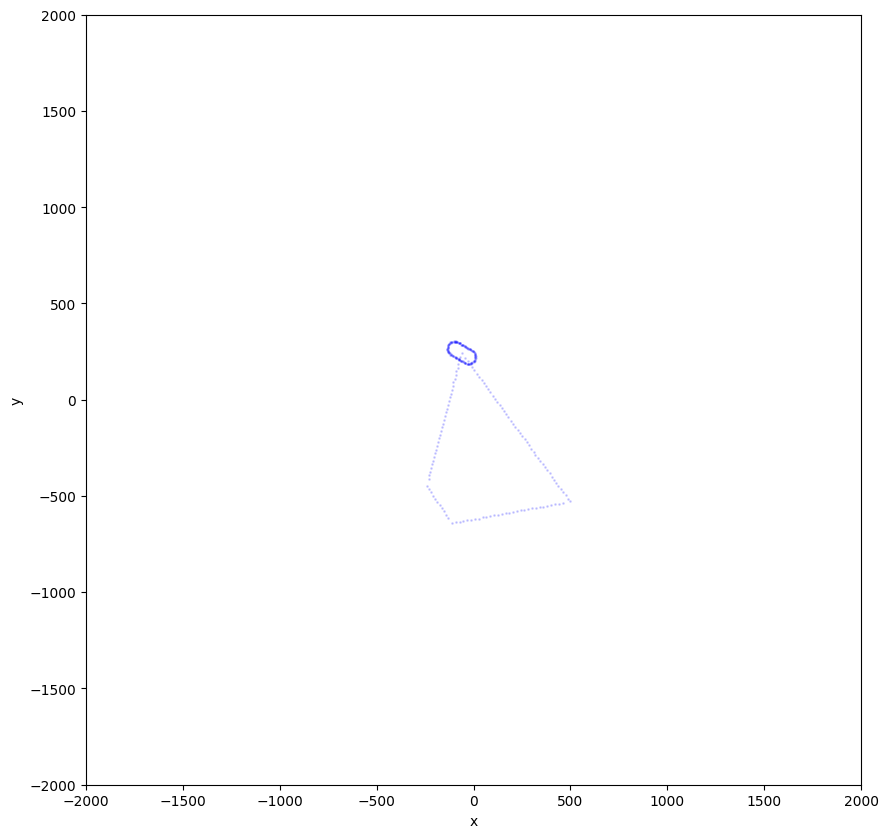

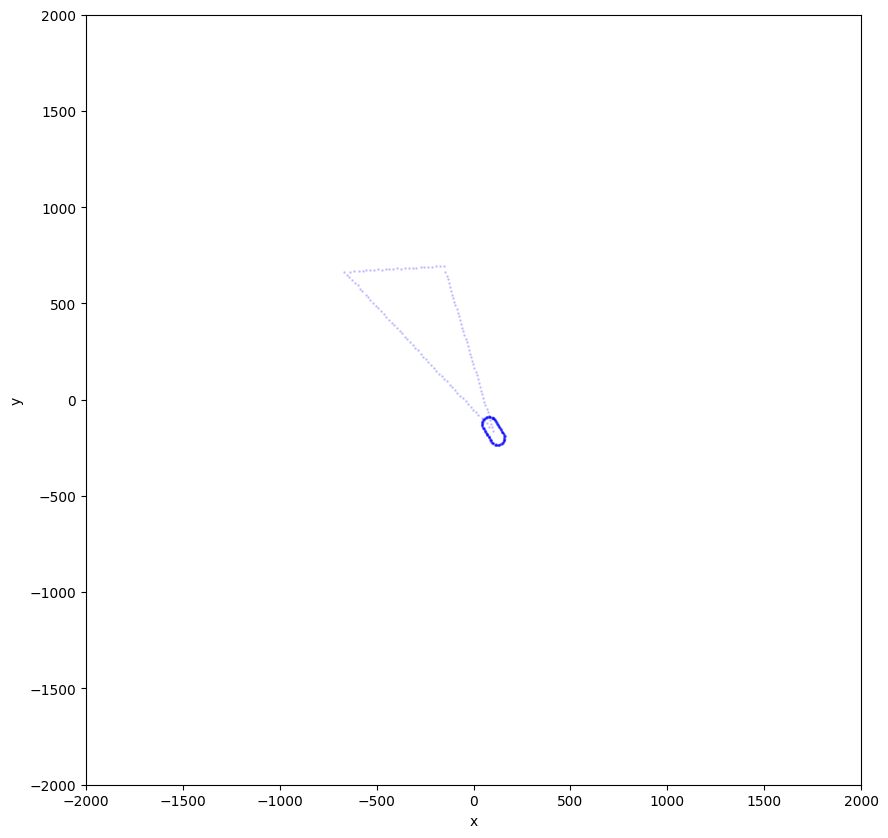

In [62]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = '/path/to/dataset/train'
KEYPOINTS_FOLDER_TEST = '/path/to/dataset/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=None, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints = 2)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    
# Save model weights after training
torch.save(model.state_dict(), '/keypoint_model/keypointsrcnn_weights.pth')

In [ ]:
iterator = iter(data_loader_test)
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)

In [ ]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)